# Machine Learning - Exercise 01
## Necessary external modules
* numpy
* scipy
* scikit-learn
* matplotlib

## DiscreteKNN
First, we'll define the basic k-nearest-neighbor algorithm for a discrete data space. This implementation receives k and an Enum class representing the discrete classes in the data space.

This class also defines a function for computing the empirical loss for a list of predicted labels correspnding to a list of test labels for the same data points.

numpy is used for computation of vector algebra (difference, norm).

In [29]:
import collections
import enum
import typing

import numpy as np

class DiscreteKNN(object):
    def __init__(self, k: int, classes: enum.Enum):
        self.trainData = np.array([], dtype=np.float)
        self.trainLabels = np.array([])
        self.k = k
        self.classes = classes

    def train(self, trainData, trainLabels):
        self.trainData = trainData
        self.trainLabels = trainLabels

    def predict(self, predicate: typing.List[typing.List[float]]):
        distances = np.linalg.norm(self.trainData - np.array(predicate), axis=1)
        kSmallest = np.argpartition(distances, self.k)[0:self.k]

        return self.classes(collections.Counter(self.trainLabels[kSmallest]).most_common(1)[0][0])

    def computeEmpiricalLoss(self, testLabels, predictedLabels):
        return (1.0 / len(predictedLabels)) * np.sum([int(a != b) for (a, b) in zip(testLabels, predictedLabels)])


## DKNNDemo
The following block defined a class for generating a semi-random dataset. This dataset is based on a gaussian distribution, generating two classes of data points. This dataset is split into train and test data using sklearn. The prediction is based on the `DiscreteKNN` class.

What follows are various data plotting functions based on matplotlib. The resulting graph is pretty self explanatory, but a note on the empirical loss for different k can be found below.

In [30]:
import enum

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

class SHAPE(enum.Enum):
    SQUARE = 0
    CIRCLE = 1

class DKNNDemo:
    def __init__(self, k=3):
        self.dataset = {
            'data': np.array([]),
            'labels': np.array([], dtype=np.uint8)
        }

        self.trainData = []
        self.trainLabels = []
        self.testData = []
        self.testLabels = []

        self.predictedLabels = []

        self.dknn = KNN.DiscreteKNN(k, SHAPE)

    def generateDataset(self, n=1000, s=0.9, y=10):
        t = s * 4.4

        np.random.seed(42)

        ax = np.abs(np.random.normal(0, s, n))
        bx = t - np.abs(np.random.normal(0, s, n))

        ax = ax[np.logical_and(0 <= ax, ax <= (t * 0.55))]
        bx = bx[np.logical_and((t * 0.45) <= bx, bx <= t)]

        ay = np.random.uniform(0, y, len(ax))
        by = np.random.uniform(0, y, len(bx))

        self.dataset['data'] = np.array([
            np.concatenate((ax, bx)),
            np.concatenate((ay, by)),
        ])
        self.dataset['labels'] = np.array(
            [SHAPE.SQUARE] * len(ax) + [SHAPE.CIRCLE] * len(bx)
        )

        self.trainData, self.testData, self.trainLabels, self.testLabels = sklearn.model_selection.train_test_split(
            self.dataset['data'].T,
            self.dataset['labels'],
            test_size=0.25,
            random_state=42
        )

    def predictTestLabels(self):
        self.dknn.train(self.trainData, self.trainLabels)
        self.predictedLabels = np.array([self.dknn.predict(d) for d in self.testData])

    def plotTrainData(self):
        plt.scatter(
            self.trainData.T[0][self.trainLabels == SHAPE.CIRCLE],
            self.trainData.T[1][self.trainLabels == SHAPE.CIRCLE],
            marker='o',
            c='b',
            alpha=0.2
        )
        plt.scatter(
            self.trainData.T[0][self.trainLabels == SHAPE.SQUARE],
            self.trainData.T[1][self.trainLabels == SHAPE.SQUARE],
            marker='s',
            c='r',
            alpha=0.2
        )
        plt.title('Train Data')

    def plotTestData(self):
        plt.scatter(
            self.testData.T[0][self.testLabels == SHAPE.CIRCLE],
            self.testData.T[1][self.testLabels == SHAPE.CIRCLE],
            marker='o',
            c='b',
            alpha=0.2
        )
        plt.scatter(
            self.testData.T[0][self.testLabels == SHAPE.SQUARE],
            self.testData.T[1][self.testLabels == SHAPE.SQUARE],
            marker='s',
            c='r',
            alpha=0.2
        )
        plt.title('Test Data')

    def plotPredictedData(self):
        plt.scatter(
            self.testData.T[0][self.predictedLabels == SHAPE.CIRCLE],
            self.testData.T[1][self.predictedLabels == SHAPE.CIRCLE],
            marker='o',
            c='b',
            alpha=0.2
        )
        plt.scatter(
            self.testData.T[0][self.predictedLabels == SHAPE.SQUARE],
            self.testData.T[1][self.predictedLabels == SHAPE.SQUARE],
            marker='s',
            c='r',
            alpha=0.2
        )
        plt.title('Predicted Test Data')

    def plotDecisionBoundary(self):
        xx, yy = np.meshgrid(
            np.arange(self.dataset['data'][0].min(), self.dataset['data'][0].max() + 0.05, 0.05),
            np.arange(self.dataset['data'][1].min(), self.dataset['data'][1].max() + 0.05, 0.05)
        )
        Z = np.array([int(self.dknn.predict(d).value) for d in np.c_[xx.ravel(), yy.ravel()]])
        Z = Z.reshape(xx.shape)

        plt.contourf(
            xx,
            yy,
            Z,
            cmap=plt.get_cmap('seismic').reversed(),
            alpha=0.2,
        )

    def plotErrors(self):
        plt.scatter(
            self.testData.T[0][self.testLabels != self.predictedLabels],
            self.testData.T[1][self.testLabels != self.predictedLabels],
            marker='x',
            c='k',
            alpha=0.4
        )
        plt.title('Wrong Predictions')

    def plotLoss(self):
        x = np.arange(1, 101, 2)
        y = []

        for k in x:
            _dknn = KNN.DiscreteKNN(k, SHAPE)
            _dknn.train(self.trainData, self.trainLabels)
            _predictedLabels = np.array([_dknn.predict(d) for d in self.testData])

            y.append(_dknn.computeEmpiricalLoss(self.testLabels, _predictedLabels))

        plt.scatter(x, y)
        plt.plot(x, y)
        plt.xticks(range(1, 102, 5))
        plt.title('Empirical Loss for different k')
        plt.xlabel('k')
        plt.ylabel('Empirical Loss')

    def plot(self):
        plt.figure(1, figsize=(20, 10))

        ax1 = plt.subplot2grid((2, 4), (0, 0))
        self.plotTrainData()

        ax2 = plt.subplot2grid((2, 4), (0, 1), sharex=ax1, sharey=ax1)
        self.plotTestData()

        ax3 = plt.subplot2grid((2, 4), (1, 0), sharex=ax1, sharey=ax1)
        self.plotPredictedData()
        self.plotDecisionBoundary()

        ax4 = plt.subplot2grid((2, 4), (1, 1), sharex=ax1, sharey=ax1)
        self.plotErrors()

        ax5 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
        self.plotLoss()

        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)
        plt.show()

    def main(self):
        self.generateDataset()
        self.predictTestLabels()


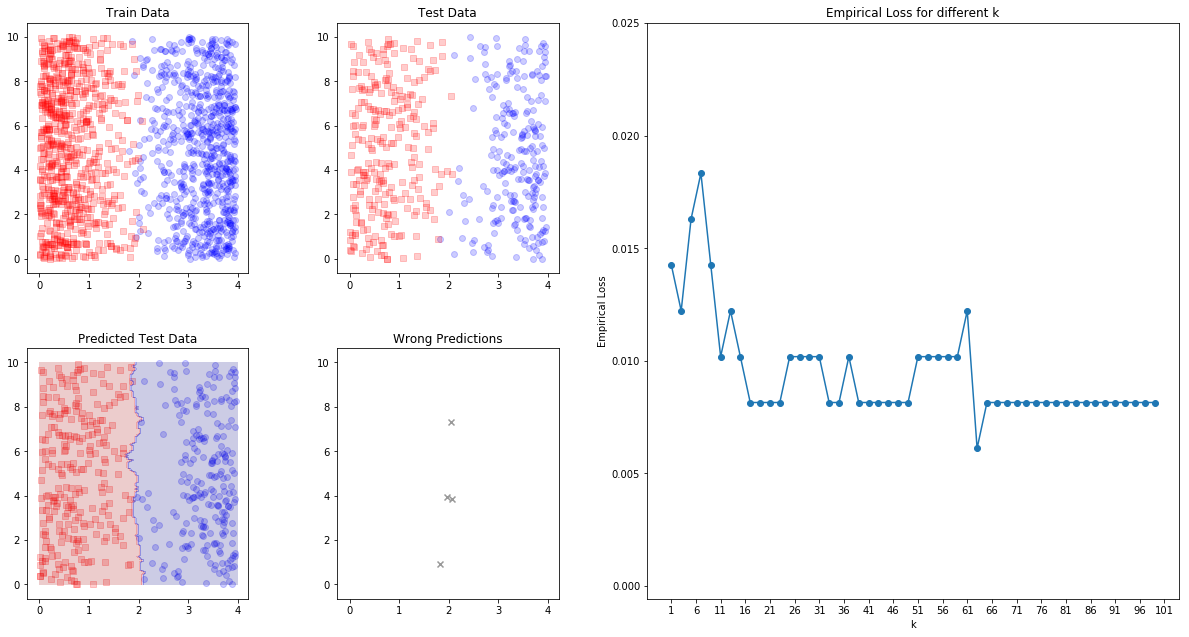

In [31]:
d = DKNNDemo(17)
d.main()
d.plot()

The figure shows plots of the  train data, as well as the test data. On the lower left, you can see the predicted labels for the given test data points. This includes the decision boundary as well. Varying k, this decision boundary tends to get smoother with higher values for k. Also, there's separat plot for the mispredictions.

On the righ is a plot of the empirical loss for different values of k. The plot is based on the same dataset. The loss seems to be pretty small already, but seems to have an local optimal value for k at 65. This would result in more computation, so using a value of 17 for k seems to give reasonable quality results.